In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import plotly.express as px

In [2]:
color_discrete_map = {
    "same_plate": "rgb(213, 94, 0)",
    "different_plates": "rgb(0, 158, 115)",
}

symbol_map = {
    "same_row_or_column": "x",
    "different_rows_and_columns": "circle",
}

### ORF

In [3]:
# Read ORF cosine similarities

orf_similarity_percentile_df = pd.read_parquet('cos_sim/cosine_similarities_percentile_genes_orf.parquet')

In [4]:
# Genes of interest
genes = ["YAP1"]

In [5]:
# Identify connections between genes of interest and all other genes

connections_df = orf_similarity_percentile_df[genes]

connections_df =connections_df.stack().reset_index().rename(columns={0:"percentile"})

connections_df = pd.concat(
    [
        connections_df,
        connections_df.rename(columns={"gene_1": "gene_2", "gene_2": "gene_1"}),
    ],
    ignore_index=True,
).drop_duplicates()

connections_df.head()

,gene_1,gene_2,percentile
0,A4GALT,YAP1,0.394120
1,A4GNT,YAP1,0.732537
2,AAAS,YAP1,0.812097
3,AADAT,YAP1,0.684398
4,AAGAB,YAP1,0.225832


In [6]:
# Add knowledge graph information and filter out any connections with low knowledge graph scores

knowledge_graph = pd.read_csv(
    "~/Downloads/orf_scores_merged.zip",
    sep="\t",
    usecols=["GENE1", "GENE2", "gene_mf__go", "gene_bp__go", "gene_pathway"],
).rename(
    columns={
        "GENE1": "gene_1",
        "GENE2": "gene_2",
        "gene_mf__go": "gene_mf",
        "gene_bp__go": "gene_bp",
    }
)

knowledge_graph = pd.concat(
    [
        knowledge_graph,
        knowledge_graph.rename(columns={"gene_1": "gene_2", "gene_2": "gene_1"}),
    ],
    ignore_index=True,
)

knowledge_graph = (
    knowledge_graph.assign(gene_kg=lambda x: np.max(
            x[["gene_mf", "gene_bp", "gene_pathway"]].abs(), axis=1
        )
    )
    .drop(columns=["gene_mf", "gene_bp", "gene_pathway"])
)

connections_df = connections_df.merge(
    knowledge_graph, on=["gene_1", "gene_2"], how="left"
)

connections_df = connections_df.query("gene_kg<0.4")

In [7]:
# Find the most similar and dissimilar genes for each ORF gene group (based on the cosine similarity percentile)

gene_list = []

for gene in genes:
    temp = connections_df.query("gene_1 == @gene").nlargest(columns="percentile", n=10)[
        "gene_2"
    ].to_list() + [gene]
    print(temp)
    gene_list.append(temp)

    temp = connections_df.query("gene_1 == @gene").nsmallest(columns="percentile", n=10)[
        "gene_2"
    ].to_list() + [gene]
    print(temp)
    gene_list.append(temp)

top_similar = np.unique(np.asarray(gene_list).flatten())

df = orf_similarity_percentile_df.loc[top_similar, top_similar]

for gene in top_similar:
    df.loc[gene, gene] = 1

['CORO2A', 'CNN1', 'CORO2B', 'RTKN', 'SYT1', 'AHDC1', 'CNN2', 'GRK2', 'INSYN1', 'RNF19B', 'YAP1']
['STK17A', 'LCOR', 'MYCT1', 'DELE1', 'SCAMP1', 'VGLL4', 'FUT8', 'VGLL3', 'P2RX2', 'B4GAT1', 'YAP1']


In [8]:
kg_df = (
    knowledge_graph[["gene_1", "gene_2", "gene_kg"]]
    .drop_duplicates()
    .pivot(columns="gene_1", index="gene_2", values="gene_kg")
    .loc[top_similar, top_similar]
    .fillna(1)
)

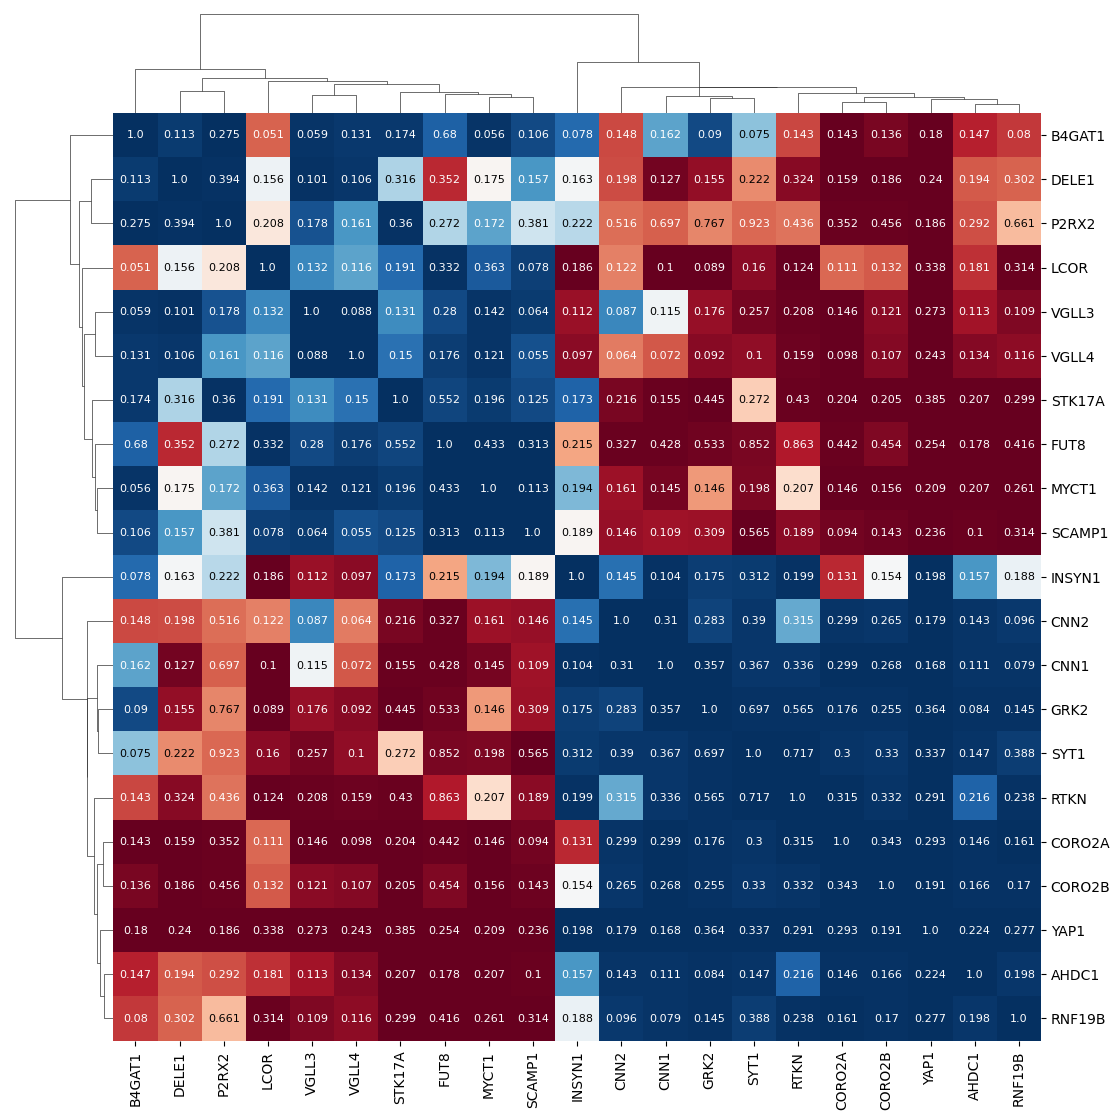

In [9]:
# Plot the heatmap

n_row = df.shape[0]
n_col = df.shape[1]
fig_width = n_row * 0.5 + 1
fig_height = n_col * 0.5 + 1

g = sns.clustermap(
    df,
    cmap="RdBu",
    vmin=0,
    vmax=1,
    dendrogram_ratio=(0.1, 0.1),
    figsize=(fig_width, fig_height),
    cbar_pos=None,
)

clustermap_df = g.data2d

for i in range(len(clustermap_df)):
    for j in range(len(clustermap_df.columns)):
        gene_1 = clustermap_df.index[i]
        gene_2 = clustermap_df.columns[j]
        kg_gene_pair = kg_df.loc[gene_1, gene_2]
        text = f"{kg_gene_pair}"
        x = j + 0.5  # Center the text horizontally
        y = i + 0.5  # Center the text vertically

        text_color = (
            "white"
            if clustermap_df.values[i, j] > 0.75 or clustermap_df.values[i, j] < 0.25
            else "black"
        )

        g.ax_heatmap.text(x, y, text, ha="center", va="center", color=text_color, fontdict={"size": 8})

g.ax_heatmap.set_xlabel("")
g.ax_heatmap.set_ylabel("")

plt.savefig(f"figures/ORF-connections-{'-'.join(top_similar)}.png", dpi=300)
plt.savefig(f"figures/ORF-connections-{'-'.join(top_similar)}.svg", dpi=300)

In [10]:
# Map gene names to NCBI gene ID

ncbi_map = pd.read_csv(
    "../00.download-and-process-annotations/output/ncbi_dataset_processed.tsv", sep="\t"
)

ncbi_map = ncbi_map.query("Approved_Symbol in @top_similar")

coexpression_df = pd.DataFrame()

for gene_id in ncbi_map.NCBI_Gene_ID:
    gene_name = ncbi_map.query("NCBI_Gene_ID == @gene_id").Approved_Symbol.values[0]
    try:
        df = pd.read_csv(
            f"../../coexpression/{gene_id}",
            header=None,
            sep="\t",
            names=["NCBI_Gene_ID", "coexpression"],
        )
        df = (
            df.merge(ncbi_map, on="NCBI_Gene_ID", how="inner")
            .drop(columns="NCBI_Gene_ID")
            .assign(gene_1=gene_name)
            .rename(columns={"Approved_Symbol": "gene_2"})
        )
        coexpression_df = pd.concat([coexpression_df, df], ignore_index=True)
    except FileNotFoundError:
        continue

coexpression_df = pd.pivot(
    coexpression_df, index="gene_1", columns="gene_2", values="coexpression"
)

coexpression_values = np.abs(coexpression_df.values)
np.fill_diagonal(coexpression_values, 1)
coexpression_df = pd.DataFrame(
    coexpression_values,
    index=coexpression_df.columns.to_list(),
    columns=coexpression_df.columns.to_list(),
)

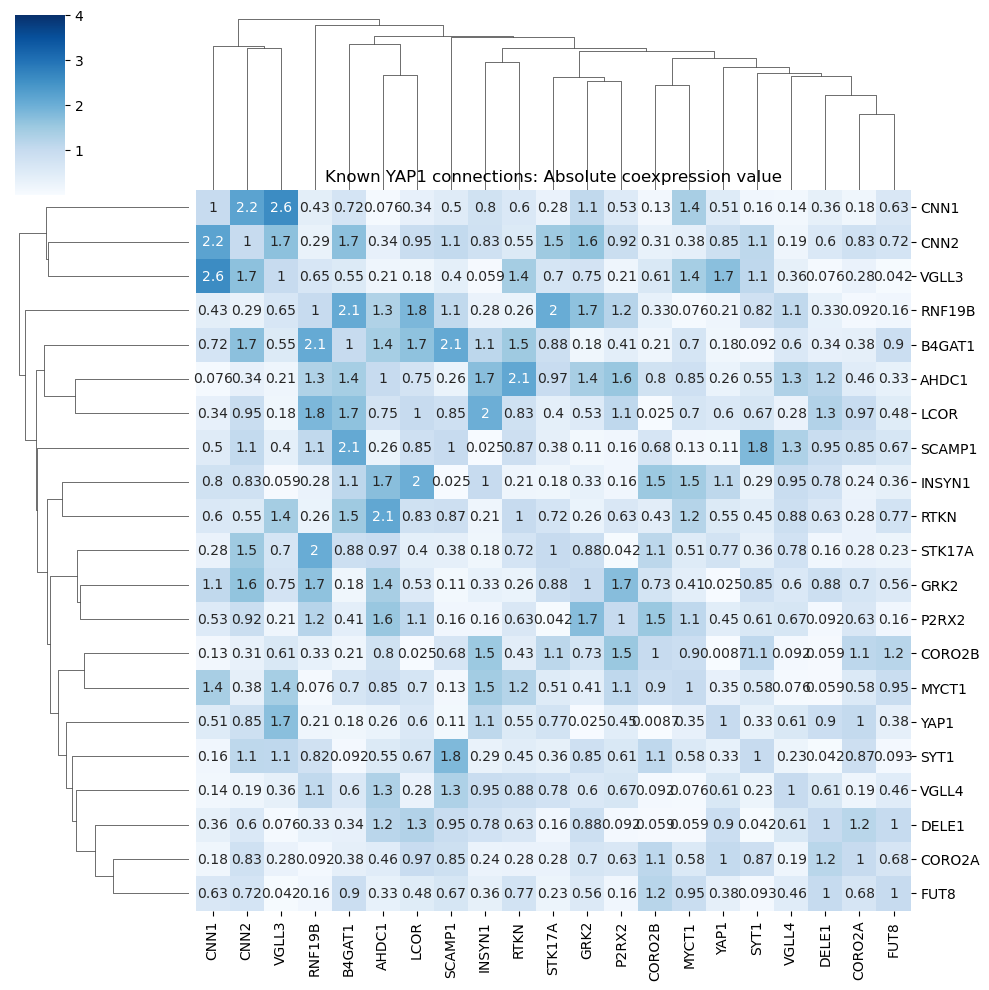

In [11]:
g = sns.clustermap(
    coexpression_df,
    cmap="Blues",
    vmin=np.min(coexpression_df.values),
    vmax=4,
    annot=True,
)
g.ax_heatmap.set_title(f"Known YAP1 connections: Absolute coexpression value")
plt.savefig(f"figures/YAP1-similar-dissimilar-coexpression.png", dpi=300)
plt.savefig(f"figures/YAP1-similar-dissimilar-coexpression.svg", dpi=300)

YAP1 is not present in the CRISPR dataset

In [12]:
orf_similarity_df = pd.read_parquet('cos_sim/cosine_similarities_genes_orf.parquet')

df = orf_similarity_df.loc[top_similar, top_similar]

for gene in top_similar:
    df.loc[gene, gene] = 1

df1 = (
    df["YAP1"]
    .reset_index()
    .rename(columns={"index": "Metadata_Gene_Symbol", "YAP1": "Similarity"})
    .assign(Similarity=lambda x: np.abs(x.Similarity))
)

df2 = (
    coexpression_df["YAP1"]
    .reset_index()
    .rename(
        columns={
            "index": "Metadata_Gene_Symbol",
            "YAP1": "Coexpression",
        }
    )
)

fig_df = (
    df1.merge(df2, on="Metadata_Gene_Symbol")
    .query("Metadata_Gene_Symbol != 'YAP1'")
)

Rsquared:0.0018391432061457547


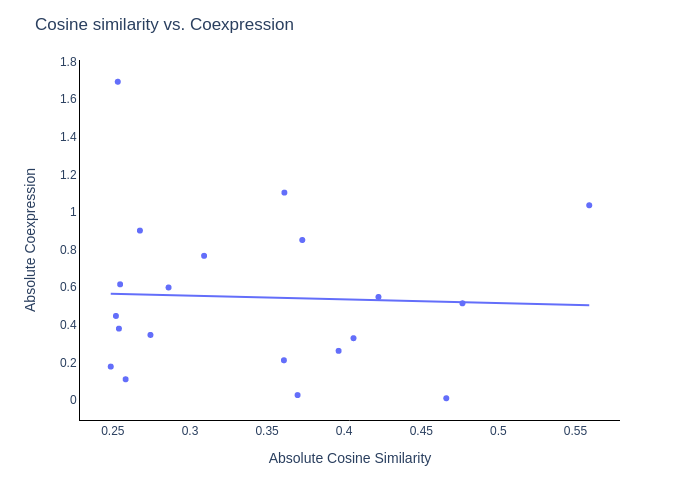

In [13]:
fig = px.scatter(
    fig_df, x="Similarity", y="Coexpression", trendline="ols"
).update_layout(
    title=f"Cosine similarity vs. Coexpression",
    xaxis=dict(title="Absolute Cosine Similarity", linecolor="black"),
    yaxis=dict(title="Absolute Coexpression", linecolor="black"),
    plot_bgcolor="white",
)
print(f"Rsquared:{px.get_trendline_results(fig).iloc[0]['px_fit_results'].rsquared}")
fig.show("png")

fig.write_image("figures/YAP1-similarity-coexpression.png", height=480, width=640, scale=2)
fig.write_image("figures/YAP1-similarity-coexpression.svg", height=480, width=640, scale=2)

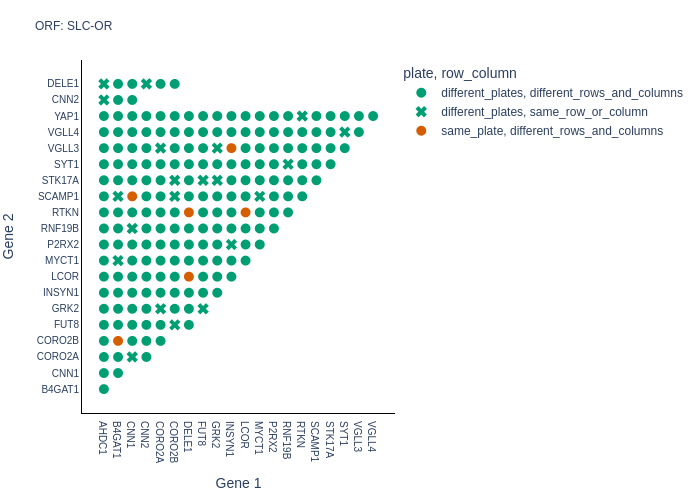

In [14]:
genes = top_similar

orf_metadata_df = pd.read_csv(
    "../00.download-and-process-annotations/output/orf_metadata.tsv.gz",
    sep="\t",
    usecols=["Metadata_JCP2022", "Metadata_Symbol"],
)

orf_profiles_with_feature_names_df = (
    pd.read_parquet("../profiles/profiles_wellpos_cc_var_mad_outlier_orf.parquet")
    .merge(orf_metadata_df, on="Metadata_JCP2022", how="inner")
    .query("Metadata_Symbol in @genes")
)

results = pd.DataFrame()
df = (
    orf_profiles_with_feature_names_df.query("Metadata_Symbol in @genes")
    .sort_values(
        by=["Metadata_Symbol", "Metadata_Plate", "Metadata_Well"], ascending=True
    )[["Metadata_Symbol", "Metadata_Plate", "Metadata_Well"]]
    .drop_duplicates(subset=["Metadata_Symbol"], keep="first")
    .assign(Metadata_Row=lambda x: x["Metadata_Well"].str[0])
    .assign(Metadata_Column=lambda x: x["Metadata_Well"].str[1:])
    .reset_index(drop=True)
)[["Metadata_Symbol", "Metadata_Plate", "Metadata_Row", "Metadata_Column"]]


for i in range(len(df)):
    for j in range(i + 1, len(df)):
        if df.loc[i, "Metadata_Plate"] == df.loc[j, "Metadata_Plate"]:
            plate = "same_plate"
        else:
            plate = "different_plates"

        if (
            df.loc[i, "Metadata_Row"] == df.loc[j, "Metadata_Row"]
            or df.loc[i, "Metadata_Column"] == df.loc[j, "Metadata_Column"]
        ):
            row_column = "same_row_or_column"
        else:
            row_column = "different_rows_and_columns"

        results = pd.concat(
            [
                results,
                pd.DataFrame(
                    {
                        "Gene_1": [df.loc[i, "Metadata_Symbol"]],
                        "Gene_2": [df.loc[j, "Metadata_Symbol"]],
                        "plate": [plate],
                        "row_column": [row_column],
                    }
                ),
            ],
            ignore_index=True,
        )

fig = (
    px.scatter(
        results,
        x="Gene_1",
        y="Gene_2",
        color="plate",
        symbol="row_column",
        color_discrete_map=color_discrete_map,
        symbol_map=symbol_map,
    )
    .update_layout(
        title=dict(text=f"ORF: SLC-OR", font=dict(size=12)),
        xaxis=dict(title="Gene 1", linecolor="black", tickfont=dict(size=10)),
        yaxis=dict(title="Gene 2", linecolor="black", tickfont=dict(size=10)),
        plot_bgcolor="white",
    )
    .update_traces(marker=dict(size=10))
)
fig.show("png")
fig.write_image(f"figures/ORF-plate-layout-YAP1.png", height=960, width=1280, scale=2)
fig.write_image(f"figures/ORF-plate-layout-YAP1.svg", height=960, width=1280, scale=2)

#### Absolute cosine similarity vs. Absolute fold change (YAP1 knockout)

In [15]:
fold_change_df = pd.read_excel(
    "input/KP.vs.KPY.tumor.differential.expression_5309results.xlsx"
)

fold_change_df = (
    fold_change_df[["Gene Symbol", "Fold Change", "q-value(%)"]].copy()
    .rename(columns={"Gene Symbol": "Metadata_Gene_Symbol", "Fold Change": "Metadata_Fold_Change", "q-value(%)": "Metadata_qvalue"})
    .assign(Metadata_Absolute_Fold_Change=lambda x: np.abs(x["Metadata_Fold_Change"]))
    .dropna()
)

fold_change_df["Metadata_Gene_Symbol"] = fold_change_df["Metadata_Gene_Symbol"].str.upper()

fold_change_df.head()

/home/niranj/miniforge3/envs/similarity/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning:

Unknown extension is not supported and will be removed



,Metadata_Gene_Symbol,Metadata_Fold_Change,Metadata_qvalue,Metadata_Absolute_Fold_Change
0,YAP1,-12.04030,0.0,12.04030
5,NRDE2,1.62205,0.0,1.62205
6,RBM25,2.87034,0.0,2.87034
9,GM3512,1.63851,0.0,1.63851
10,GM15789,3.05857,0.0,3.05857


In [16]:
fig_df = fig_df.merge(fold_change_df, on="Metadata_Gene_Symbol", how="left")

fig_df.head()

,Metadata_Gene_Symbol,Similarity,Coexpression,Metadata_Fold_Change,Metadata_qvalue,Metadata_Absolute_Fold_Change
0,AHDC1,0.396364,0.2608,-1.23677,60.3713,1.23677
1,B4GAT1,0.248625,0.1771,NaN,NaN,NaN
2,CNN1,0.476689,0.5139,1.18906,84.6134,1.18906
3,CNN2,0.372812,0.8508,-1.51694,84.6803,1.51694
4,CORO2A,0.558896,1.0356,1.44943,65.8483,1.44943


Rsquared:0.0626917984610943


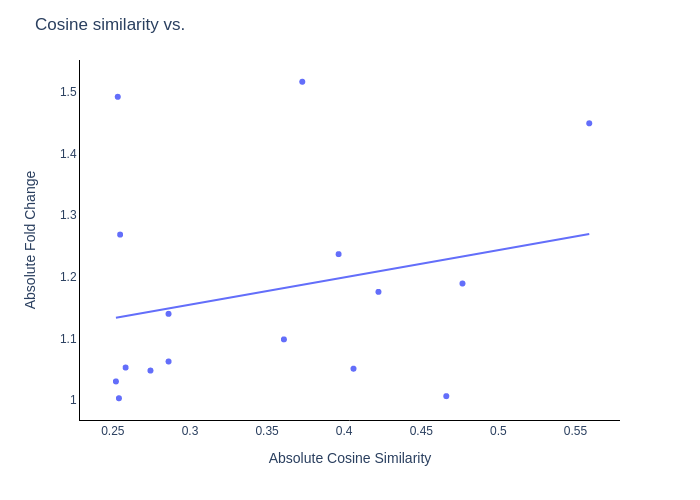

In [17]:
fig = px.scatter(
    fig_df,
    x="Similarity",
    y="Metadata_Absolute_Fold_Change",
    trendline="ols",
).update_layout(
    title=f"Cosine similarity vs. ",
    xaxis=dict(title="Absolute Cosine Similarity", linecolor="black"),
    yaxis=dict(title="Absolute Fold Change", linecolor="black"),
    plot_bgcolor="white",
)
print(f"Rsquared:{px.get_trendline_results(fig).iloc[0]['px_fit_results'].rsquared}")
fig.show("png")

fig.write_image(
    "figures/YAP1-similarity-fold-change.png", height=480, width=640, scale=2
)
fig.write_image(
    "figures/YAP1-similarity-fold-change.svg", height=480, width=640, scale=2
)

In [18]:
df = orf_similarity_df.loc[top_similar, top_similar]

for gene in top_similar:
    df.loc[gene, gene] = 1

df1 = (
    df["YAP1"]
    .reset_index()
    .rename(columns={"index": "Metadata_Gene_Symbol", "YAP1": "Similarity"})
)

fig_df = df1.merge(fold_change_df, on="Metadata_Gene_Symbol", how="left")

fig_df = fig_df.query("Metadata_Gene_Symbol!='YAP1'").dropna().reset_index(drop=True)

fig_df.head()

,Metadata_Gene_Symbol,Similarity,Metadata_Fold_Change,Metadata_qvalue,Metadata_Absolute_Fold_Change
0,AHDC1,0.396364,-1.23677,60.3713,1.23677
1,CNN1,0.476689,1.18906,84.6134,1.18906
2,CNN2,0.372812,-1.51694,84.6803,1.51694
3,CORO2A,0.558896,1.44943,65.8483,1.44943
4,CORO2B,0.466192,1.00602,84.6134,1.00602


Rsquared:0.031122143065951624


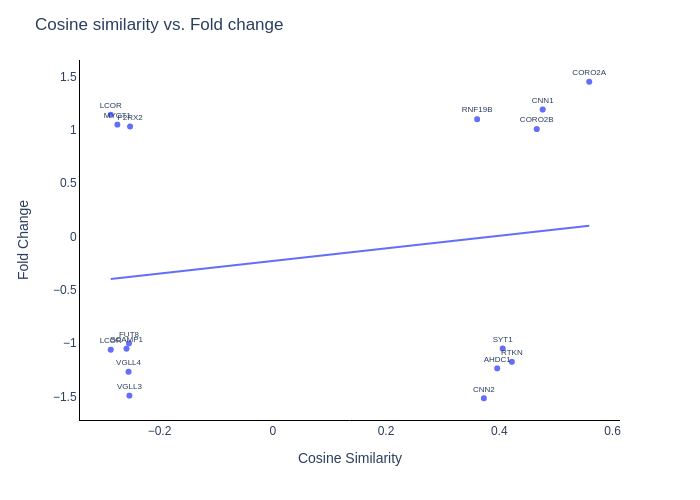

In [19]:
fig = px.scatter(
    fig_df,
    x="Similarity",
    y="Metadata_Fold_Change",
    trendline="ols",
    text="Metadata_Gene_Symbol",
).update_layout(
    title=f"Cosine similarity vs. Fold change",
    xaxis=dict(title="Cosine Similarity", linecolor="black"),
    yaxis=dict(title="Fold Change", linecolor="black"),
    plot_bgcolor="white",
).update_traces(textposition='top center', textfont_size=8)

print(f"Rsquared:{px.get_trendline_results(fig).iloc[0]['px_fit_results'].rsquared}")
fig.show("png")

fig.write_image(
    "figures/YAP1-similarity-fold-change_directionality.png", height=480, width=640, scale=2
)
fig.write_image(
    "figures/YAP1-similarity-fold-change_directionality.svg", height=480, width=640, scale=2
)

In [20]:
print(fig_df[["Metadata_Gene_Symbol", "Similarity", "Metadata_qvalue"]].to_markdown(index=False))

| Metadata_Gene_Symbol   |   Similarity |   Metadata_qvalue |
|:-----------------------|-------------:|------------------:|
| AHDC1                  |     0.396364 |           60.3713 |
| CNN1                   |     0.476689 |           84.6134 |
| CNN2                   |     0.372812 |           84.6803 |
| CORO2A                 |     0.558896 |           65.8483 |
| CORO2B                 |     0.466192 |           84.6134 |
| FUT8                   |    -0.253937 |           87.586  |
| LCOR                   |    -0.286104 |           75.7986 |
| LCOR                   |    -0.286104 |           87.586  |
| MYCT1                  |    -0.274379 |           84.6134 |
| P2RX2                  |    -0.251989 |           65.8483 |
| RNF19B                 |     0.36091  |           84.6134 |
| RTKN                   |     0.422219 |           86.5241 |
| SCAMP1                 |    -0.258267 |           87.586  |
| SYT1                   |     0.406036 |           87.586  |
| VGLL3 

In [21]:
fold_change_df = fold_change_df.query("Metadata_qvalue < 5")

In [22]:
connections_df = orf_similarity_percentile_df[genes]

connections_df =connections_df.stack().reset_index().rename(columns={0:"percentile"})

connections_df = pd.concat(
    [
        connections_df,
        connections_df.rename(columns={"gene_1": "gene_2", "gene_2": "gene_1"}),
    ],
    ignore_index=True,
).drop_duplicates().query("gene_1=='YAP1'").rename(columns={"gene_2": "Metadata_Gene_Symbol"})

connections_df.head()

,gene_1,Metadata_Gene_Symbol,percentile
142863,YAP1,AHDC1,0.998233
142864,YAP1,B4GAT1,0.001259
142865,YAP1,CNN1,0.999188
142866,YAP1,CNN2,0.997744
142867,YAP1,CORO2A,0.999629


In [23]:
fold_change_df = (
    fold_change_df.merge(connections_df, on="Metadata_Gene_Symbol", how="inner")
    .rename(columns={"percentile": "cosine_similarity_percentile"})
    .drop(columns=["gene_1"])
    .sort_values("cosine_similarity_percentile", ascending=False)
)
fold_change_df.head()

,Metadata_Gene_Symbol,Metadata_Fold_Change,Metadata_qvalue,Metadata_Absolute_Fold_Change,cosine_similarity_percentile
13,CEP72,1.38714,3.903290,1.38714,0.991001
16,MTMR9,1.95756,4.470400,1.95756,0.981028
6,SPATA7,1.76291,2.382770,1.76291,0.816803
2,HNRNPDL,1.49019,0.815263,1.49019,0.689962
5,ALKBH3,1.28788,1.730650,1.28788,0.581412


In [24]:
print(
    fold_change_df[
        [
            "Metadata_Gene_Symbol",
            "Metadata_Fold_Change",
            "Metadata_qvalue",
            "cosine_similarity_percentile",
        ]
    ].to_markdown(index=False)
)

| Metadata_Gene_Symbol   |   Metadata_Fold_Change |   Metadata_qvalue |   cosine_similarity_percentile |
|:-----------------------|-----------------------:|------------------:|-------------------------------:|
| CEP72                  |                1.38714 |          3.90329  |                      0.991001  |
| MTMR9                  |                1.95756 |          4.4704   |                      0.981028  |
| SPATA7                 |                1.76291 |          2.38277  |                      0.816803  |
| HNRNPDL                |                1.49019 |          0.815263 |                      0.689962  |
| ALKBH3                 |                1.28788 |          1.73065  |                      0.581412  |
| FAM107A                |                1.36986 |          2.38277  |                      0.502607  |
| TAF1B                  |                1.64345 |          3.90329  |                      0.437225  |
| TRAF6                  |                1.59328 |    